In [1]:
from sklearn import metrics
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from dataCentric_functions import *

import medmnist
from medmnist import INFO, Evaluator

In [2]:
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG, Adam, SGD
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score
from libauc.models import resnet18 as ResNet18

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score
#from pytorchtools import EarlyStopping
import sys

In [3]:
import matplotlib.pyplot as plt

In [4]:
data_flag = 'nodulemnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
info

{'python_class': 'NoduleMNIST3D',
 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1',
 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3',
 'task': 'binary-class',
 'label': {'0': 'benign', '1': 'malignant'},
 'n_channels': 1,
 'n_samples': {'train': 1158, 'val': 165, 'test': 310},
 'license': 'CC BY 4.0'}

In [6]:
# preprocessing

data_transform1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])


In [7]:
train_dataset1 = DataClass(split='train', transform=data_transform1, download=download)
val_dataset1 = DataClass(split='val', transform=data_transform1, download=download)
test_dataset = DataClass(split='test', transform=data_transform1, download=download)

train_dataset1

Using downloaded and verified file: /Users/chihoonlee/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /Users/chihoonlee/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /Users/chihoonlee/.medmnist/nodulemnist3d.npz


Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 1158
    Root location: /Users/chihoonlee/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.
    License: CC BY 4.0

In [8]:
train_counts = np.unique(train_dataset1.labels, return_counts=True)
val_counts = np.unique(val_dataset1.labels, return_counts=True)
print(f"class ratio: {train_counts}")
print(f"class ratio: {val_counts}")
print(f"class ratio: {np.unique(test_dataset.labels, return_counts=True)}")
train_val_comb = train_counts[1] + val_counts[1]
neg_counts, pos_counts = train_val_comb[0], train_val_comb[1]
print(f"train+validation class ratio: {neg_counts, pos_counts}")

class ratio: (array([0, 1], dtype=uint8), array([863, 295]))
class ratio: (array([0, 1], dtype=uint8), array([123,  42]))
class ratio: (array([0, 1], dtype=uint8), array([246,  64]))
train+validation class ratio: (986, 337)


As we see from the number of counts of each class in the dataset, this dataset is imbalanced, and we are going to balance it by upsampling technique.

Step 1: Data shifting (balance data if imblance by upsampling)

In [9]:
ct_tensors_img = torch.cat([torch.from_numpy(train_dataset1.imgs), torch.from_numpy(val_dataset1.imgs)])
ct_tensors_labels = torch.cat([torch.from_numpy(train_dataset1.labels), torch.from_numpy(val_dataset1.labels)])
ct_tensors_img.shape

torch.Size([1323, 28, 28, 28])

Step 2: data augmentation

In [10]:
# We will overcome the data imbalance issue by upsamling the minority class using data augmentation
# since the majority class is almost three times as many as the minority class, 
# two data augmentation techniques will be employed to increase the number of images in the minority class

# two augmentation combination: HorizontalFlip and Gaussian Noise
data_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=1.0)
])
data_transform3 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.2)
])

In [11]:
# Data upsampling function
def create_new_img_by_augmentations(desired_class, data_transform):
    # load more training and validation dataset to create new data using data augmentation
    # param: desired_class(list) is a list of classes to be kept,
    # and all the other classes not in this list will be filtered out
    # param: data_transform(pytorch.transforms) is a data transform method to be applied to dataset
    # return: pytorch dataset
    train_dataset = DataClass(split='train', transform=data_transform)
    val_dataset = DataClass(split='val', transform=data_transform)
    '''
    filtered_trainset = torch.utils.data.Subset(train_dataset,
                            [i for i in range(len(train_dataset)) if train_dataset.labels[i] in desired_class])
    filtered_valset = torch.utils.data.Subset(val_dataset,
                            [i for i in range(len(val_dataset)) if val_dataset.labels[i] in desired_class])
    '''
    
    combined_imgs = torch.cat([torch.from_numpy(train_dataset.imgs), torch.from_numpy(val_dataset.imgs)])
    combined_labels = torch.cat([torch.from_numpy(train_dataset.labels), torch.from_numpy(val_dataset.labels)])
    
    desired_class_idx = [i for i in range(len(combined_labels)) if combined_labels[i] in desired_class]
    
    #print(combined_imgs.shape)
    #print(combined_labels.shape)
    combined_imgs = combined_imgs[desired_class_idx, :, :, :]
    combined_labels = combined_labels[desired_class_idx]
    
    #return combined_imgs, combined_labels
    
    combined_train = torch.utils.data.TensorDataset(combined_imgs, combined_labels)
    
    #combined_train = torch.utils.data.ConcatDataset([filtered_trainset, filtered_valset])
    return combined_train

In [12]:
desired_class = [1]
new_combined_train = torch.utils.data.ConcatDataset([create_new_img_by_augmentations(desired_class,
                                                                                     data_transform=data_transform2),
                                               create_new_img_by_augmentations(desired_class,
                                                                               data_transform=data_transform3)])
len(new_combined_train)

674

In [13]:
#i, l = create_new_img_by_augmentations(desired_class, data_transform=data_transform2)
#l.unique(return_counts=True)
#t_v = create_new_img_by_augmentations(desired_class, data_transform=data_transform2)
#len(t_v)

In [16]:
from math import ceil

count_diff = int(max(neg_counts, pos_counts) - min(neg_counts, pos_counts))
random_sampler = data.RandomSampler(new_combined_train, num_samples=count_diff)
added_dataloader = data.DataLoader(new_combined_train, batch_size=BATCH_SIZE, sampler=random_sampler)

added_diter = iter(added_dataloader)
examples, labels = next(added_diter)
added_tensors_img, added_tensors_labels = examples, labels
#for i in range(1, ceil(len(combined_train) / BATCH_SIZE)):
for i in range(1, ceil(count_diff / BATCH_SIZE)):
    examples, labels = next(added_diter)
    added_tensors_img = torch.cat([added_tensors_img, examples])
    added_tensors_labels = torch.cat([added_tensors_labels, labels])

X = torch.cat([ct_tensors_img, added_tensors_img])
y = torch.cat([ct_tensors_labels, added_tensors_labels])
X = X.float()

In [17]:
y.unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([986, 986]))

In [18]:
# splitting train and validation data with balanced ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
len(X_train)

1577

In [19]:
train_d = torch.utils.data.TensorDataset(X_train, y_train)
val_d = torch.utils.data.TensorDataset(X_val, y_val)

trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE, shuffle=True)
valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [20]:
# resnet18 model
from libauc.models import resnet18 as ResNet18

#writer = SummaryWriter("runs/breast")
model = ResNet18(pretrained=False, last_activation=None, num_classes=1)
model.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)


# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001


# loss and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

#writer.add_graph(model=model)  # graph of model structure
#writer.close()
#sys.exit()



In [21]:
# early stopping patience; how long to wait after last time validation loss improved.
patience=12
train_log, val_log = train(model, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, 
                           valloader, patience=patience, decay_epochs=decay_epochs)

Start Training
------------------------------
epoch: 0, train_loss: 0.1929, train_auc: 0.5659, val_auc: 0.5384, lr: 0.1000
0
epoch: 1, train_loss: 0.1348, train_auc: 0.8136, val_auc: 0.7936, lr: 0.1000
0
epoch: 2, train_loss: 0.1032, train_auc: 0.6526, val_auc: 0.6196, lr: 0.1000
1
epoch: 3, train_loss: 0.0949, train_auc: 0.8824, val_auc: 0.8339, lr: 0.1000
0
epoch: 4, train_loss: 0.0751, train_auc: 0.8940, val_auc: 0.8790, lr: 0.1000
0
epoch: 5, train_loss: 0.0536, train_auc: 0.9327, val_auc: 0.9055, lr: 0.1000
0
epoch: 6, train_loss: 0.0426, train_auc: 0.9233, val_auc: 0.9000, lr: 0.1000
1
epoch: 7, train_loss: 0.0397, train_auc: 0.9455, val_auc: 0.9253, lr: 0.1000
0
epoch: 8, train_loss: 0.0326, train_auc: 0.9668, val_auc: 0.9223, lr: 0.1000
1
epoch: 9, train_loss: 0.0239, train_auc: 0.9772, val_auc: 0.9474, lr: 0.1000
0
epoch: 10, train_loss: 0.0165, train_auc: 0.9755, val_auc: 0.9239, lr: 0.1000
1
epoch: 11, train_loss: 0.0172, train_auc: 0.9848, val_auc: 0.9484, lr: 0.1000
0
epoc

Text(0.5, 0, 'Epoch')

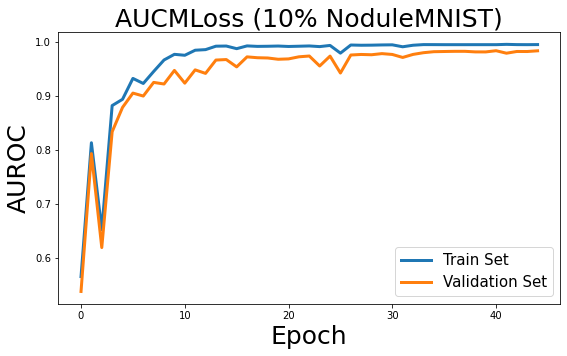

In [22]:
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, linestyle='-', label='Train Set', linewidth=3)
plt.plot(x, val_log,  linestyle='-', label='Validation Set', linewidth=3)
plt.title('AUCMLoss (10% NoduleMNIST)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)

In [23]:
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=BATCH_SIZE)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = model(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.8127


In [24]:
# save the model1
torch.save(model.state_dict(), "nodule/nodule_model1.pth")

In [25]:
# Back to Step 2
# two augmentation combination: HorizontalFlip and Normalize
data_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=1.0)
])
data_transform4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [26]:
desired_class = [1]
new_combined_train = torch.utils.data.ConcatDataset([create_new_img_by_augmentations(desired_class,
                                                                                     data_transform=data_transform2),
                                               create_new_img_by_augmentations(desired_class,
                                                                               data_transform=data_transform4)])
len(new_combined_train)

674

In [27]:
count_diff = int(max(neg_counts, pos_counts) - min(neg_counts, pos_counts))
random_sampler = data.RandomSampler(new_combined_train, num_samples=count_diff)
added_dataloader = data.DataLoader(new_combined_train, batch_size=BATCH_SIZE, sampler=random_sampler)

added_diter = iter(added_dataloader)
examples, labels = next(added_diter)
added_tensors_img, added_tensors_labels = examples, labels
#for i in range(1, ceil(len(combined_train) / BATCH_SIZE)):
for i in range(1, ceil(count_diff / BATCH_SIZE)):
    examples, labels = next(added_diter)
    added_tensors_img = torch.cat([added_tensors_img, examples])
    added_tensors_labels = torch.cat([added_tensors_labels, labels])

X = torch.cat([ct_tensors_img, added_tensors_img])
y = torch.cat([ct_tensors_labels, added_tensors_labels])
X = X.float()

In [28]:
y.unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([986, 986]))

In [29]:
# splitting train and validation data with balanced ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
len(X_train)

1577

In [30]:
train_d = torch.utils.data.TensorDataset(X_train, y_train)
val_d = torch.utils.data.TensorDataset(X_val, y_val)

trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE, shuffle=True)
valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [31]:
# resnet18 model
from libauc.models import resnet18 as ResNet18

#writer = SummaryWriter("runs/breast")
model2 = ResNet18(pretrained=False, last_activation=None, num_classes=1)
model2.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)


# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001


# loss and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model2, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

#writer.add_graph(model=model)  # graph of model structure
#writer.close()
#sys.exit()



In [32]:
# early stopping patience; how long to wait after last time validation loss improved.
patience=12
train_log, val_log = train(model2, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, 
                           valloader, patience=patience, decay_epochs=decay_epochs)

Start Training
------------------------------
epoch: 0, train_loss: 0.1833, train_auc: 0.5079, val_auc: 0.5031, lr: 0.1000
0
epoch: 1, train_loss: 0.1409, train_auc: 0.8402, val_auc: 0.8567, lr: 0.1000
0
epoch: 2, train_loss: 0.1028, train_auc: 0.8211, val_auc: 0.8439, lr: 0.1000
1
epoch: 3, train_loss: 0.0810, train_auc: 0.8510, val_auc: 0.8416, lr: 0.1000
2
epoch: 4, train_loss: 0.0628, train_auc: 0.9311, val_auc: 0.9014, lr: 0.1000
0
epoch: 5, train_loss: 0.0590, train_auc: 0.9145, val_auc: 0.8709, lr: 0.1000
1
epoch: 6, train_loss: 0.0467, train_auc: 0.9216, val_auc: 0.8897, lr: 0.1000
0
epoch: 7, train_loss: 0.0337, train_auc: 0.9623, val_auc: 0.9296, lr: 0.1000
0
epoch: 8, train_loss: 0.0216, train_auc: 0.9460, val_auc: 0.9150, lr: 0.1000
1
epoch: 9, train_loss: 0.0252, train_auc: 0.9821, val_auc: 0.9536, lr: 0.1000
0
epoch: 10, train_loss: 0.0115, train_auc: 0.9830, val_auc: 0.9622, lr: 0.1000
0
epoch: 11, train_loss: 0.0103, train_auc: 0.9839, val_auc: 0.9629, lr: 0.1000
1
epoc

Text(0.5, 0, 'Epoch')

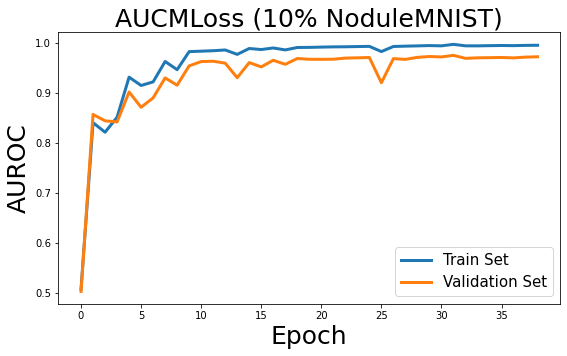

In [33]:
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, linestyle='-', label='Train Set', linewidth=3)
plt.plot(x, val_log,  linestyle='-', label='Validation Set', linewidth=3)
plt.title('AUCMLoss (10% NoduleMNIST)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)

In [34]:
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=BATCH_SIZE)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = model2(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.8521


In [35]:
# save the model2
torch.save(model2.state_dict(), "nodule/nodule_model2.pth")

In [36]:
# Back to Step 2
# two augmentation combination: Gaussian Noise and Normalize
# load more training and validation dataset to create new data using data augmentation
desired_class = [1]
new_combined_train = torch.utils.data.ConcatDataset([create_new_img_by_augmentations(desired_class,
                                                                                     data_transform=data_transform3),
                                               create_new_img_by_augmentations(desired_class,
                                                                               data_transform=data_transform4)])
new_combined_train

In [37]:
count_diff = int(max(neg_counts, pos_counts) - min(neg_counts, pos_counts))
random_sampler = data.RandomSampler(new_combined_train, num_samples=count_diff)
added_dataloader = data.DataLoader(new_combined_train, batch_size=BATCH_SIZE, sampler=random_sampler)

added_diter = iter(added_dataloader)
examples, labels = next(added_diter)
added_tensors_img, added_tensors_labels = examples, labels
#for i in range(1, ceil(len(combined_train) / BATCH_SIZE)):
for i in range(1, ceil(count_diff / BATCH_SIZE)):
    examples, labels = next(added_diter)
    added_tensors_img = torch.cat([added_tensors_img, examples])
    added_tensors_labels = torch.cat([added_tensors_labels, labels])

X = torch.cat([ct_tensors_img, added_tensors_img])
y = torch.cat([ct_tensors_labels, added_tensors_labels])
X = X.float()

In [38]:
y.unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([986, 986]))

In [39]:
# splitting train and validation data with balanced ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
len(X_train)

1577

In [40]:
train_d = torch.utils.data.TensorDataset(X_train, y_train)
val_d = torch.utils.data.TensorDataset(X_val, y_val)

trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE, shuffle=True)
valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [41]:
# resnet18 model
from libauc.models import resnet18 as ResNet18

#writer = SummaryWriter("runs/breast")
model3 = ResNet18(pretrained=False, last_activation=None, num_classes=1)
model3.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)


# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001


# loss and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model3, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

#writer.add_graph(model=model)  # graph of model structure
#writer.close()
#sys.exit()



In [42]:
# early stopping patience; how long to wait after last time validation loss improved.
patience=12
train_log, val_log = train(model3, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, 
                           valloader, patience=patience, decay_epochs=decay_epochs)

Start Training
------------------------------
epoch: 0, train_loss: 0.2038, train_auc: 0.5533, val_auc: 0.5866, lr: 0.1000
0
epoch: 1, train_loss: 0.1571, train_auc: 0.6919, val_auc: 0.6954, lr: 0.1000
0
epoch: 2, train_loss: 0.1110, train_auc: 0.7993, val_auc: 0.8112, lr: 0.1000
0
epoch: 3, train_loss: 0.1128, train_auc: 0.8202, val_auc: 0.8345, lr: 0.1000
0
epoch: 4, train_loss: 0.0856, train_auc: 0.8534, val_auc: 0.8620, lr: 0.1000
0
epoch: 5, train_loss: 0.0743, train_auc: 0.8374, val_auc: 0.8463, lr: 0.1000
1
epoch: 6, train_loss: 0.0534, train_auc: 0.9331, val_auc: 0.9040, lr: 0.1000
0
epoch: 7, train_loss: 0.0404, train_auc: 0.9477, val_auc: 0.9149, lr: 0.1000
0
epoch: 8, train_loss: 0.0302, train_auc: 0.9308, val_auc: 0.8938, lr: 0.1000
1
epoch: 9, train_loss: 0.0255, train_auc: 0.9475, val_auc: 0.9161, lr: 0.1000
0
epoch: 10, train_loss: 0.0188, train_auc: 0.9466, val_auc: 0.9031, lr: 0.1000
1
epoch: 11, train_loss: 0.0203, train_auc: 0.9666, val_auc: 0.9296, lr: 0.1000
0
epoc

Text(0.5, 0, 'Epoch')

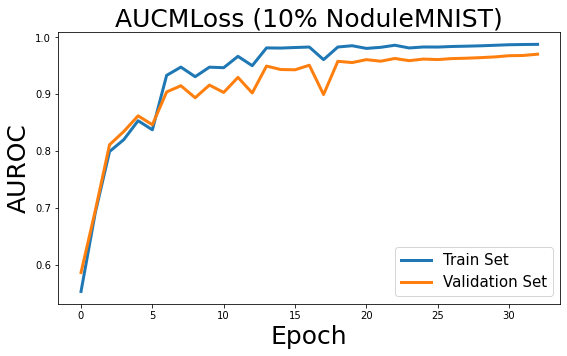

In [43]:
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, linestyle='-', label='Train Set', linewidth=3)
plt.plot(x, val_log,  linestyle='-', label='Validation Set', linewidth=3)
plt.title('AUCMLoss (10% NoduleMNIST)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)

In [44]:
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=BATCH_SIZE)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = model3(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.8711


In [45]:
# save the model3
torch.save(model3.state_dict(), "nodule/nodule_model3.pth")

In [46]:
# Back to Step 2
# two augmentation combination: Flipping, Gaussian Noise, and Normalize
# load more training and validation dataset to create new data using data augmentation
desired_class = [1]
new_combined_train = torch.utils.data.ConcatDataset([create_new_img_by_augmentations(desired_class,
                                                                                     data_transform=data_transform2),
                                                     create_new_img_by_augmentations(desired_class,
                                                                                     data_transform=data_transform3),
                                               create_new_img_by_augmentations(desired_class,
                                                                               data_transform=data_transform4)])
len(new_combined_train)

1011

In [47]:
count_diff = int(max(neg_counts, pos_counts) - min(neg_counts, pos_counts))
random_sampler = data.RandomSampler(new_combined_train, num_samples=count_diff)
added_dataloader = data.DataLoader(new_combined_train, batch_size=BATCH_SIZE, sampler=random_sampler)

added_diter = iter(added_dataloader)
examples, labels = next(added_diter)
added_tensors_img, added_tensors_labels = examples, labels
#for i in range(1, ceil(len(combined_train) / BATCH_SIZE)):
for i in range(1, ceil(count_diff / BATCH_SIZE)):
    examples, labels = next(added_diter)
    added_tensors_img = torch.cat([added_tensors_img, examples])
    added_tensors_labels = torch.cat([added_tensors_labels, labels])

X = torch.cat([ct_tensors_img, added_tensors_img])
y = torch.cat([ct_tensors_labels, added_tensors_labels])
X = X.float()

In [48]:
y.unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([986, 986]))

In [49]:
# splitting train and validation data with balanced ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
len(X_train)

1577

In [50]:
train_d = torch.utils.data.TensorDataset(X_train, y_train)
val_d = torch.utils.data.TensorDataset(X_val, y_val)

trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE, shuffle=True)
valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [51]:
# resnet18 model
from libauc.models import resnet18 as ResNet18

#writer = SummaryWriter("runs/breast")
model4 = ResNet18(pretrained=False, last_activation=None, num_classes=1)
model4.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)


# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001


# loss and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model4, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

#writer.add_graph(model=model)  # graph of model structure
#writer.close()
#sys.exit()



In [52]:
# early stopping patience; how long to wait after last time validation loss improved.
patience=12
train_log, val_log = train(model4, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, 
                           valloader, patience=patience, decay_epochs=decay_epochs)

Start Training
------------------------------
epoch: 0, train_loss: 0.1864, train_auc: 0.5932, val_auc: 0.6069, lr: 0.1000
0
epoch: 1, train_loss: 0.1389, train_auc: 0.8019, val_auc: 0.8031, lr: 0.1000
0
epoch: 2, train_loss: 0.0915, train_auc: 0.8978, val_auc: 0.8617, lr: 0.1000
0
epoch: 3, train_loss: 0.0701, train_auc: 0.7957, val_auc: 0.7446, lr: 0.1000
1
epoch: 4, train_loss: 0.0752, train_auc: 0.8978, val_auc: 0.8220, lr: 0.1000
0
epoch: 5, train_loss: 0.0398, train_auc: 0.9426, val_auc: 0.9013, lr: 0.1000
0
epoch: 6, train_loss: 0.0308, train_auc: 0.9542, val_auc: 0.9058, lr: 0.1000
1
epoch: 7, train_loss: 0.0213, train_auc: 0.9693, val_auc: 0.9161, lr: 0.1000
0
epoch: 8, train_loss: 0.0201, train_auc: 0.9787, val_auc: 0.9216, lr: 0.1000
0
epoch: 9, train_loss: 0.0179, train_auc: 0.9664, val_auc: 0.9266, lr: 0.1000
0
epoch: 10, train_loss: 0.0139, train_auc: 0.9765, val_auc: 0.9284, lr: 0.1000
1
epoch: 11, train_loss: 0.0118, train_auc: 0.9804, val_auc: 0.9279, lr: 0.1000
2
epoc

Text(0.5, 0, 'Epoch')

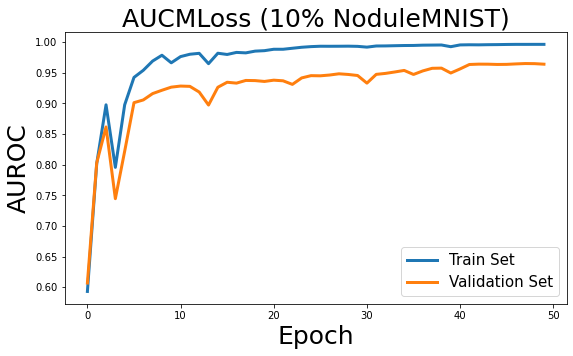

In [53]:
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, linestyle='-', label='Train Set', linewidth=3)
plt.plot(x, val_log,  linestyle='-', label='Validation Set', linewidth=3)
plt.title('AUCMLoss (10% NoduleMNIST)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)

In [54]:
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=BATCH_SIZE)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = model4(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.8424


In [55]:
# save the model4
torch.save(model4.state_dict(), "nodule/nodule_model4.pth")

Data created by augmentation techniques Gaussian Noise and data created by Normalize generated the top performing ResNet model. So, the dataset we will use for the next steps will be that one.

Combined Step 4 & 5: Optimizer selection. Tune optimizer, batch size, and step size and Hyperparameter tuning. Lastly, model training and testing with the best dataset

In [62]:
# two augmentation combination: Gaussian Noise and Normalize
# load more training and validation dataset to create new data using data augmentation
desired_class = [1]
new_combined_train = torch.utils.data.ConcatDataset([create_new_img_by_augmentations(desired_class,
                                                                                     data_transform=data_transform3),
                                               create_new_img_by_augmentations(desired_class,
                                                                               data_transform=data_transform4)])
new_combined_train

In [66]:
# construct upsampled dataset
BATCH_SIZE = 128
count_diff = int(max(neg_counts, pos_counts) - min(neg_counts, pos_counts))
random_sampler = data.RandomSampler(new_combined_train, num_samples=count_diff)
added_dataloader = data.DataLoader(new_combined_train, batch_size=BATCH_SIZE, sampler=random_sampler)

added_diter = iter(added_dataloader)
examples, labels = next(added_diter)
added_tensors_img, added_tensors_labels = examples, labels
#for i in range(1, ceil(len(combined_train) / BATCH_SIZE)):
for i in range(1, ceil(count_diff / BATCH_SIZE)):
    examples, labels = next(added_diter)
    added_tensors_img = torch.cat([added_tensors_img, examples])
    added_tensors_labels = torch.cat([added_tensors_labels, labels])

X = torch.cat([ct_tensors_img, added_tensors_img])
y = torch.cat([ct_tensors_labels, added_tensors_labels])

X = X.float()
y.unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([986, 986]))

In [67]:
# splitting train and validation data with balanced ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
len(X_train)

1577

In [68]:
train_d = torch.utils.data.TensorDataset(X_train, y_train)
val_d = torch.utils.data.TensorDataset(X_val, y_val)

#trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE, shuffle=True)
#valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
#trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [71]:
# resnet18 model
from libauc.models import resnet18 as ResNet18

SEED = 123
imratio = 0.1 # for demo 
total_epochs = 50
decay_epochs = [50, 75]


margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001

# HyperParameters
optmzr = ['adam', 'PESG']
BATCH_SIZE = [128, 256]
lr = [1e-3, 1e-1]

max_auc = 0
best_hyperparams = []  # optimizer, batch_size, lr order
best_model = None
# hyperparameter tuning based on gridsearch
for i in range(len(optmzr)*len(BATCH_SIZE)*len(lr)):
    model_i = ResNet18(pretrained=False, last_activation=None, num_classes=1, )
    model_i.conv1 = torch.nn.Conv2d(X_train.shape[1], 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    lr_idx = i % len(lr)
    batch_idx = (i // len(lr)) % len(BATCH_SIZE)
    optmzr_idx = i // (len(lr) * len(BATCH_SIZE))
    
    trainloader = data.DataLoader(dataset=train_d, batch_size=BATCH_SIZE[batch_idx], shuffle=True)
    valloader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE[batch_idx], shuffle=False, num_workers=2)
    trainloader_eval = data.DataLoader(train_d, batch_size=BATCH_SIZE[batch_idx], shuffle=False, num_workers=2)
    

    # loss and optimizer
    loss_fn = AUCMLoss()

    if optmzr[optmzr_idx] == 'adam':  # use adam optimizer
        #optimizer = torch.optim.Adam(model_i.parameters(), lr=lr[lr_idx], weight_decay=weight_decay)
        optimizer = Adam(model_i,
                 lr=lr[lr_idx],
                 weight_decay=weight_decay)
    elif optmzr[optmzr_idx] == 'momentum':  # use momentous SGD optimzer
        #optimizer = optim.SGD(model_i.parameters(), lr=lr[lr_idx], momentum=0.9)
        optimizer = SGD(model_i, 
                 lr=lr[lr_idx],
                 momentum=0.9,
                 weight_decay=weight_decay)
    else:  # PESG
        optimizer = PESG(model_i, 
                 loss_fn=loss_fn,
                 lr=lr[lr_idx], 
                 momentum=0.9,
                 #margin=margin)
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)
    
    print(f"optimzer: {optmzr[optmzr_idx]}, step size: {lr[lr_idx]}, batch size: {BATCH_SIZE[batch_idx]}")
    train(model_i, loss_fn, optimizer, total_epochs, trainloader, trainloader_eval, valloader,
          patience=7, decay_epochs=decay_epochs)

    # evaluate the performance on validation set to select the best hyperparameters
    val_loader = data.DataLoader(dataset=val_d, batch_size=BATCH_SIZE[batch_idx], num_workers=2)
    score_list = list()
    label_list = list()
    for _, d in enumerate(val_loader, 0):
        tmp_data, tmp_label = d
        #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()

        tmp_score = model_i(tmp_data).detach().clone().cpu()
        #print(tmp_score)
        score_list.append(tmp_score)
        label_list.append(tmp_label.cpu())

    val_label = torch.cat(label_list)
    val_score = torch.cat(score_list)

    val_auc = metrics.roc_auc_score(val_label, val_score)                   
    print("Validation : %.4f"%val_auc, flush=True)
                        #val_auc??
    if val_auc > max_auc:
        #val_auc??
        max_auc = val_auc #val_auc?
        best_hyperparams = [optmzr[optmzr_idx], lr[lr_idx], BATCH_SIZE[batch_idx]]
        best_model = model_i

optimzer: adam, step size: 0.001, batch size: 128
Start Training
------------------------------
epoch: 0, train_loss: 0.0147, train_auc: 0.4719, val_auc: 0.4698, lr: 0.0010
0
epoch: 1, train_loss: 0.0000, train_auc: 0.5214, val_auc: 0.5211, lr: 0.0010
0
epoch: 2, train_loss: 0.0000, train_auc: 0.4978, val_auc: 0.4655, lr: 0.0010
1
epoch: 3, train_loss: 0.0000, train_auc: 0.4695, val_auc: 0.4605, lr: 0.0010
2
epoch: 4, train_loss: 0.0000, train_auc: 0.4701, val_auc: 0.4751, lr: 0.0010
0
epoch: 5, train_loss: 0.0000, train_auc: 0.4814, val_auc: 0.4891, lr: 0.0010
0
epoch: 6, train_loss: 0.0000, train_auc: 0.4836, val_auc: 0.4904, lr: 0.0010
1
epoch: 7, train_loss: 0.0000, train_auc: 0.4863, val_auc: 0.4844, lr: 0.0010
2
epoch: 8, train_loss: 0.0000, train_auc: 0.4882, val_auc: 0.4763, lr: 0.0010
3
epoch: 9, train_loss: 0.0000, train_auc: 0.4967, val_auc: 0.4728, lr: 0.0010
4
epoch: 10, train_loss: 0.0000, train_auc: 0.4910, val_auc: 0.4711, lr: 0.0010
5
epoch: 11, train_loss: 0.0000, tra

epoch: 24, train_loss: 0.0000, train_auc: 0.5000, val_auc: 0.5052, lr: 0.1000
1
epoch: 25, train_loss: 0.0000, train_auc: 0.5000, val_auc: 0.5052, lr: 0.1000
2
epoch: 26, train_loss: 0.0000, train_auc: 0.5006, val_auc: 0.5128, lr: 0.1000
0
epoch: 27, train_loss: 0.0000, train_auc: 0.5006, val_auc: 0.5129, lr: 0.1000
1
epoch: 28, train_loss: 0.0000, train_auc: 0.5000, val_auc: 0.5052, lr: 0.1000
2
epoch: 29, train_loss: 0.0000, train_auc: 0.5006, val_auc: 0.5129, lr: 0.1000
0
epoch: 30, train_loss: 0.0000, train_auc: 0.5000, val_auc: 0.5052, lr: 0.1000
1
epoch: 31, train_loss: 0.0000, train_auc: 0.5000, val_auc: 0.5000, lr: 0.1000
2
epoch: 32, train_loss: 0.0000, train_auc: 0.5000, val_auc: 0.4948, lr: 0.1000
3
epoch: 33, train_loss: 0.0000, train_auc: 0.4994, val_auc: 0.4923, lr: 0.1000
4
epoch: 34, train_loss: 0.0000, train_auc: 0.4994, val_auc: 0.4871, lr: 0.1000
5
epoch: 35, train_loss: 0.0000, train_auc: 0.5006, val_auc: 0.5023, lr: 0.1000
0
epoch: 36, train_loss: 0.0000, train_auc

epoch: 1, train_loss: 0.0429, train_auc: 0.5231, val_auc: 0.5280, lr: 0.0010
1
epoch: 2, train_loss: 0.0446, train_auc: 0.5290, val_auc: 0.5138, lr: 0.0010
2
epoch: 3, train_loss: 0.0471, train_auc: 0.5357, val_auc: 0.5052, lr: 0.0010
3
epoch: 4, train_loss: 0.0495, train_auc: 0.5287, val_auc: 0.4957, lr: 0.0010
4
epoch: 5, train_loss: 0.0535, train_auc: 0.5297, val_auc: 0.4879, lr: 0.0010
5
epoch: 6, train_loss: 0.0568, train_auc: 0.5356, val_auc: 0.4814, lr: 0.0010
6
epoch: 7, train_loss: 0.0614, train_auc: 0.5411, val_auc: 0.4839, lr: 0.0010
7
Early stopping
Validation : 0.4757
optimzer: PESG, step size: 0.1, batch size: 256
Start Training
------------------------------
epoch: 0, train_loss: 0.1675, train_auc: 0.4963, val_auc: 0.4944, lr: 0.1000
0
epoch: 1, train_loss: 0.2017, train_auc: 0.6893, val_auc: 0.7022, lr: 0.1000
0
epoch: 2, train_loss: 0.1403, train_auc: 0.5838, val_auc: 0.6042, lr: 0.1000
1
epoch: 3, train_loss: 0.1164, train_auc: 0.5471, val_auc: 0.5348, lr: 0.1000
2
ep

In [72]:
batch_size = best_hyperparams[2]
X_test = torch.from_numpy(test_dataset.imgs)
X_test = X_test.float()
test_d = torch.utils.data.TensorDataset(X_test, torch.from_numpy(test_dataset.labels))

test_loader = data.DataLoader(dataset=test_d, batch_size=batch_size)

# Testing AUC
score_list = list()
label_list = list()
for _, d in enumerate(test_loader, 0):
    tmp_data, tmp_label = d
    #tmp_data, tmp_label = tmp_data.cuda(), tmp_label.cuda()
    
    tmp_score = best_model(tmp_data).detach().clone().cpu()
    score_list.append(tmp_score)
    label_list.append(tmp_label.cpu())

test_label = torch.cat(label_list)
test_score = torch.cat(score_list)
                   
test_auc = metrics.roc_auc_score(test_label, test_score)                   
print("Test : %.4f"%test_auc, flush=True)

Test : 0.8016


In [73]:
best_model

ResNet(
  (conv1): Conv2d(28, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [74]:
# save the best model
torch.save(best_model.state_dict(), "nodule/nodule_hyperparam.pth")

In [ ]:
# load the model
net = ResNet18(pretrained=False)
#net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
net.load_state_dict(torch.load("saved_model/test_model"))
model.eval()